# Spotify classifier and recommendation system

## 1. fetching data from my spotify api

we have our client id and secret created on spotify developer page. we will be using spotipy liberary to fetch data and will authenticate it.

In [1]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import calendar
from sklearn.decomposition import PCA
sns.set()

Reading our client id and secret from the text file below

In [2]:
'''f = open("C:/Users/dar/Downloads/Codeop-projects-master/Codeop-projects-master/spotify classifier and recommendation system/notebooks_neha/credentials.txt","r")
CLIENT_ID = f.readline().replace('\n','')
CLIENT_SECRET = f.readline().replace('\n','')'''

'f = open("C:/Users/dar/Downloads/Codeop-projects-master/Codeop-projects-master/spotify classifier and recommendation system/notebooks_neha/credentials.txt","r")\nCLIENT_ID = f.readline().replace(\'\n\',\'\')\nCLIENT_SECRET = f.readline().replace(\'\n\',\'\')'

To authorize your API calls without going through the headache of verifying the redirect URL. Just make use of the oauth2 method:

In [ ]:
"""client_credentials_manager = oauth2.SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)
"""

In the next cell we are going to create a function to fetch data using spotify special functions. we nee audio features in our playlist and thats what is important for our analysis

In [ ]:
"""# Function to get song features from a playlist
def get_playlist_songs(username, playlist_id):
    # Get songs from playlist
    playlist = sp.user_playlist_tracks(username, playlist_id)
    songs = playlist['items']
    while playlist['next']:
        playlist = sp.next(playlist) # use sp.next method to overcome fetch limit of 100 songs
        songs.extend(playlist['items'])
    # Create a list with song ids
    song_ids = [] 
    for i in range(len(songs)): 
        song_ids.append(songs[i]["track"]["id"]) 
    # Create a dataframe with features for each song
    songs_df = pd.DataFrame()
    for song_id in song_ids:
        features = sp.audio_features(song_id) 
        songs_df = songs_df.append(pd.DataFrame(features), ignore_index=True)
    return songs_df"""

Calling the above function with playlist name and link attributes to fetch data from user's playlist

In [ ]:
"""liked_songs = get_playlist_songs("liked_songs", "https://open.spotify.com/playlist/1V1mZJF1frwOfuJilP3MOw?si=fb33832f6d144a25")
disliked_songs = get_playlist_songs("disliked_songs", "https://open.spotify.com/playlist/20irwPoCwqCBGzmGKxOqGt?si=4175d107c1004965")
"""

We have 3 users, each user has liked songs and disliked songs playlist. In total 6 datafiles for all the users.

In [3]:
liked_songs = pd.read_csv("liked_songs.csv")
liked_songs_1 = pd.read_csv("C:/Users/nehas/OneDrive/Desktop/liked_songs.csv")
disliked_songs_1 = pd.read_csv("C:/Users/nehas/OneDrive/Desktop/disliked_songs.csv")
disliked_songs = pd.read_csv("disliked_songs.csv")
liked_songs_2 = pd.read_csv("C:/Users/nehas/OneDrive/Desktop/liked.csv")
disliked_songs_2 = pd.read_csv("C:/Users/nehas/OneDrive/Desktop/DislikedSongs.csv")

Our first idea is to create a classifier to see wheter a user will like a song or not, for that purpose we create a feature named target with value 0 if user doesn.t like the song and with value 1 means user likes the song

In [4]:
disliked_songs['target'] = 0
liked_songs['target'] = 1
disliked_songs_1['target'] = 0
liked_songs_1['target'] = 1
disliked_songs_2['target'] = 0
liked_songs_2['target'] = 1

Lets merge all the dataframes together as df

In [14]:
data = pd.concat([liked_songs,disliked_songs,liked_songs_1,disliked_songs_1,liked_songs_2,disliked_songs_2], axis = 0).reset_index(drop=True)


As we are merging 3 user's data, there is a possibility of duplicate values in the dataframe, We are going to create a copy of our data dtaframe and drop some columns which are of no use and then we will drop all the duplicates.

#### string columns
- id	-string-	The Spotify ID for the track.
- uri	-string-	The Spotify URI for the track.
- track_href	-string-	A link to the Web API endpoint providing full details of the track.
- analysis_url	-string-	An HTTP URL to access the full audio analysis of this track. An access token is required to access this data.
- type	-string-	The object type: “audio_features”

In [15]:
df = data.drop(columns=['type','id','uri','track_href','analysis_url'])

In [16]:
df.drop_duplicates(inplace=True,keep='first')

In [17]:
df.shape

(11038, 14)

Now at last we have 11038 rows and 14 columns in our dataframe.

## 2.  EDA (Exploratry Data Analysis) 


In [18]:
print(df.shape)
df.head()

(11038, 14)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,target
0,0.417,0.934,7,-3.908,0,0.1190,0.000278,0.001500,0.1320,0.287,127.066,210240,4,1
1,0.538,0.981,1,-2.688,0,0.1400,0.006620,0.000000,0.2190,0.711,101.414,255467,4,1
2,0.364,0.922,0,-4.217,0,0.0567,0.000915,0.034600,0.0697,0.227,79.342,235053,4,1
3,0.458,0.783,8,-3.226,0,0.0322,0.346000,0.000006,0.1300,0.224,113.072,167907,3,1
4,0.451,0.889,1,-2.693,1,0.2610,0.001670,0.002150,0.2580,0.586,131.073,153800,4,1


In [19]:
print(df[df['target']==0].shape)
print(df[df['target']==1].shape)

(5448, 14)
(5590, 14)


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11038 entries, 0 to 13880
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      11038 non-null  float64
 1   energy            11038 non-null  float64
 2   key               11038 non-null  int64  
 3   loudness          11038 non-null  float64
 4   mode              11038 non-null  int64  
 5   speechiness       11038 non-null  float64
 6   acousticness      11038 non-null  float64
 7   instrumentalness  11038 non-null  float64
 8   liveness          11038 non-null  float64
 9   valence           11038 non-null  float64
 10  tempo             11038 non-null  float64
 11  duration_ms       11038 non-null  int64  
 12  time_signature    11038 non-null  int64  
 13  target            11038 non-null  int64  
dtypes: float64(9), int64(5)
memory usage: 1.3 MB


We have 13 songs features like energy, key, mode etc and one target variable in our dataframe.there are no null values and no duplicates in it.

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
danceability,11038.0,0.620190,0.152344,0.000000,0.517000,0.632000,0.732000,0.982
energy,11038.0,0.639591,0.198437,0.000219,0.501000,0.660500,0.796000,0.999
key,11038.0,5.306124,3.559467,0.000000,2.000000,5.000000,8.000000,11.000
loudness,11038.0,-7.211682,3.098775,-34.475000,-8.743750,-6.683000,-5.047250,0.638
mode,11038.0,0.605273,0.488814,0.000000,0.000000,1.000000,1.000000,1.000
speechiness,11038.0,0.090197,0.091208,0.000000,0.036800,0.053000,0.100000,0.957
acousticness,11038.0,0.307857,0.294222,0.000004,0.050225,0.204000,0.536000,0.995
instrumentalness,11038.0,0.020118,0.101298,0.000000,0.000000,0.000002,0.000184,0.988
liveness,11038.0,0.194196,0.162453,0.000000,0.095200,0.128000,0.245000,0.986
valence,11038.0,0.527741,0.228932,0.000000,0.349000,0.529500,0.713000,0.983


Lets have a look to the average song audio features value for a liked song and of disliked song.

In [25]:
# Get an 'average song' that represents what I like
like_avg = df[df['target'] == 1].describe().loc[['mean','std']]

average_song = df[
    (df['danceability'] < like_avg.danceability[0]+like_avg.danceability[1]) & (df['danceability'] > like_avg.danceability[0]-like_avg.danceability[1]) &
    (df['energy'] < like_avg.energy[0]+like_avg.energy[1]) & (df['energy'] > like_avg.energy[0]-like_avg.energy[1]) &
    (df['loudness'] < like_avg.loudness[0]+like_avg.loudness[1]) & (df['loudness'] > like_avg.loudness[0]-like_avg.loudness[1]) &
    (df['speechiness'] < like_avg.speechiness[0]+like_avg.speechiness[1]) & (df['speechiness'] > like_avg.speechiness[0]-like_avg.speechiness[1]) &
    (df['acousticness'] < like_avg.acousticness[0]+like_avg.acousticness[1]) & (df['acousticness'] > like_avg.acousticness[0]-like_avg.acousticness[1]) &
    (df['instrumentalness'] < like_avg.instrumentalness[0]+like_avg.instrumentalness[1]) & (df['instrumentalness'] > like_avg.instrumentalness[0]-like_avg.instrumentalness[1]) &
    (df['liveness'] < like_avg.liveness[0]+like_avg.liveness[1]) & (df['liveness'] > like_avg.liveness[0]-like_avg.liveness[1]) &
    (df['valence'] < like_avg.valence[0]+like_avg.valence[1]) & (df['valence'] > like_avg.valence[0]-like_avg.valence[1]) &
    (df['tempo'] < like_avg.tempo[0]+like_avg.tempo[1]) & (df['tempo'] > like_avg.tempo[0]-like_avg.tempo[1]) &
    (df['mode'] == 1) &
    (df['key'] == 0) &
    (df['time_signature'] == 4)
]

# Pick one average LIKE song
average_song.iloc[1].to_frame().T



,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,target
518,0.655,0.469,0.0,-6.257,1.0,0.0292,0.173,0.0,0.0956,0.467,92.56,161385.0,4.0,1.0


In [24]:

# Get an 'average song' that represents what I don't like
nlike_avg = df[df['target'] == 0].describe().loc[['mean','std']]

average_song = df[
    (df['danceability'] < nlike_avg.danceability[0]+nlike_avg.danceability[1]) & (df['danceability'] > nlike_avg.danceability[0]-nlike_avg.danceability[1]) &
    (df['energy'] < nlike_avg.energy[0]+nlike_avg.energy[1]) & (df['energy'] > nlike_avg.energy[0]-nlike_avg.energy[1]) &
    (df['loudness'] < nlike_avg.loudness[0]+nlike_avg.loudness[1]) & (df['loudness'] > nlike_avg.loudness[0]-nlike_avg.loudness[1]) &
    (df['speechiness'] < nlike_avg.speechiness[0]+nlike_avg.speechiness[1]) & (df['speechiness'] > nlike_avg.speechiness[0]-nlike_avg.speechiness[1]) &
    (df['acousticness'] < nlike_avg.acousticness[0]+nlike_avg.acousticness[1]) & (df['acousticness'] > nlike_avg.acousticness[0]-nlike_avg.acousticness[1]) &
    (df['instrumentalness'] < nlike_avg.instrumentalness[0]+nlike_avg.instrumentalness[1]) & (df['instrumentalness'] > nlike_avg.instrumentalness[0]-nlike_avg.instrumentalness[1]) &
    (df['liveness'] < nlike_avg.liveness[0]+nlike_avg.liveness[1]) & (df['liveness'] > nlike_avg.liveness[0]-nlike_avg.liveness[1]) &
    (df['valence'] < nlike_avg.valence[0]+nlike_avg.valence[1]) & (df['valence'] > nlike_avg.valence[0]-nlike_avg.valence[1]) &
    (df['tempo'] < nlike_avg.tempo[0]+nlike_avg.tempo[1]) & (df['tempo'] > nlike_avg.tempo[0]-nlike_avg.tempo[1]) &
    (df['mode'] == 1) &
    (df['key'] == 7) &
    (df['time_signature'] == 4)
]

# Pick one average NOT_LIKE song
average_song.iloc[-1].to_frame().T


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,target
13856,0.72,0.672,7.0,-6.852,1.0,0.0551,0.009,0.0,0.232,0.705,124.986,204640.0,4.0,0.0


We have 3 categorical features and 10 numerical features and one binary value feature, lets create seperate list for all type

In [26]:
# List of 13 song features
# All features
song_features = list(df.describe().columns)
# Target feature
song_target = 'target'
# Categorical features
song_features_cat = ['key', 'mode', 'time_signature']
# Continuos features
song_features_cont = [feature for feature in song_features if feature not in song_features_cat+[song_target]]

In [27]:
song_features_cont

['danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms']

Now lets visualize our data for better understanding

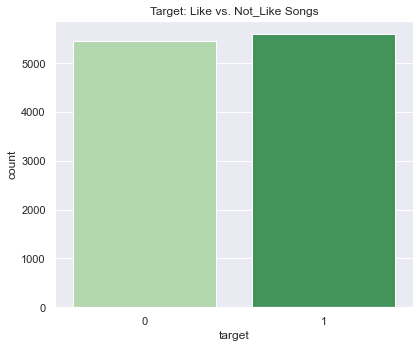

In [30]:
# Plot target variable 'like' counts
plt.figure(figsize=(6,5))
sns.countplot(x=song_target, 
              data=df,
              palette='Greens')
plt.title('Target: Like vs. Not_Like Songs', fontsize=12)
plt.tight_layout();

We have almost similar datapoints for like and dislike songs in our dataframe. 

<ipython-input-32-bc87551ac9a3>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrow,ncol,i+1)
<ipython-input-32-bc87551ac9a3>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrow,ncol,i+1)
<ipython-input-32-bc87551ac9a3>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrow,ncol,i+1)
<ipython-input-32-bc87551ac9a3>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrow,ncol,i+1)
<ipython-input-32-bc87551ac9a3>:7: MatplotlibDeprecationWarning: Passing non-integers as three-eleme

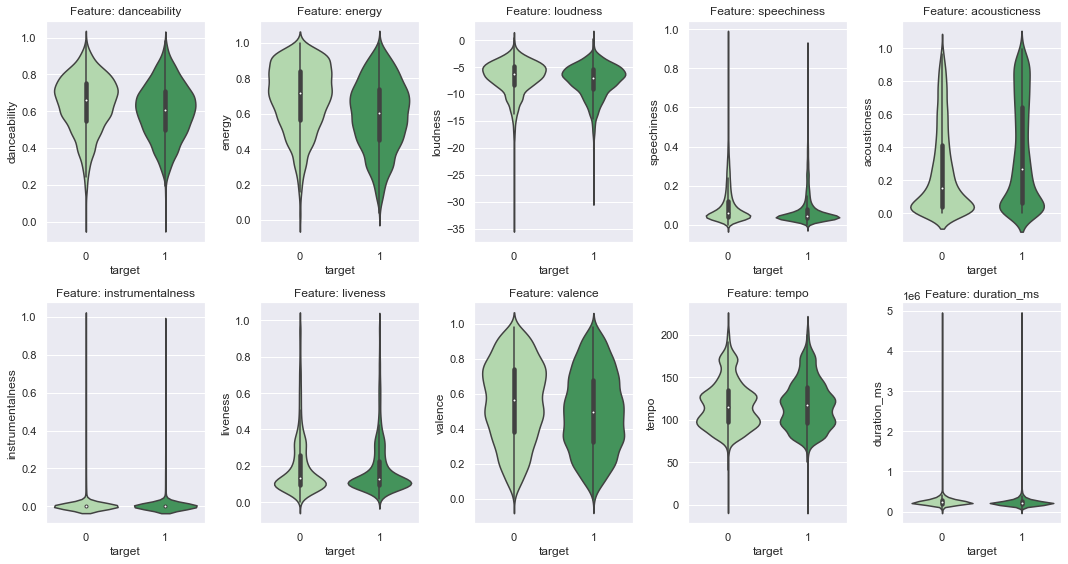

In [32]:
# Plot continuous features
ncol = 5
nrow = len(song_features_cont) / ncol
    
plt.figure(figsize=(15,8))
for i, feat in enumerate(song_features_cont):
    plt.subplot(nrow,ncol,i+1)
    sns.violinplot(y=feat, 
                   x=song_target,
                   data=df,
                   palette='Greens')
    plt.title('Feature: ' + feat, fontsize=12)
plt.tight_layout();

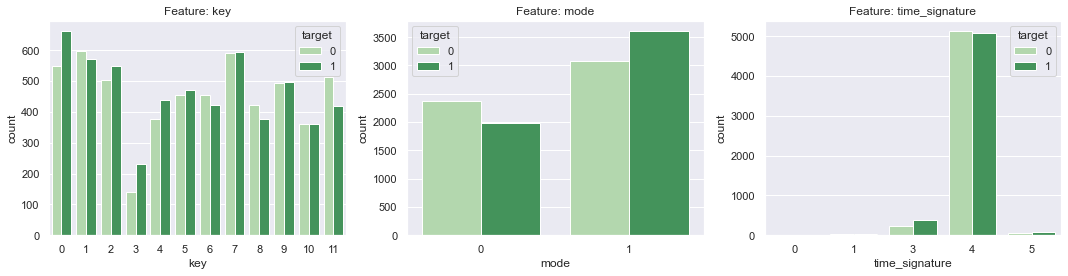

In [33]:
# Plot categorical features
ncol = len(song_features_cat)
nrow = 1

plt.figure(figsize=(15,4))
for i, feat in enumerate(song_features_cat):
    plt.subplot(nrow,ncol,i+1)
    sns.countplot(x=feat, 
                  data=df,
                  hue=song_target,
                  palette='Greens')
    plt.title('Feature: ' + feat, fontsize=12)
plt.tight_layout();

- danceability	-float-	Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

- tempo	-float-	The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. The distribution of values for this feature look like this:Tempo distribution

- valence	-float-	A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). The distribution of values for this feature look like this:Valence distribution


- acousticness	-float-	A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. The distribution of values for this feature look like this:Acousticness distribution

- mode	-int-	Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

- energy	-float-	Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. 

- instrumentalness	-float-	Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

- liveness	-float-	Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. The distribution of values for this feature look like this:Liveness distribution

- loudness	-float-	The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. The distribution of values for this feature look like this:Loudness distribution

- speechiness	-float-	Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. The distribution of values for this feature look like this:Speechiness distribution

- duration_ms	-int-	The duration of the track in milliseconds.

- key	-int-	The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

- time_signature	-int-	An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

- any relation between columns?

Define function to perform mannwhitney test and get pvalue to identify which features have different distributions when comparing like and not_like songs

In [35]:
def get_mannwhitney_p(group1, group2, features):
    pval_dict = {}
    for feat in features:
        stat, p = mannwhitneyu(group1[feat], group2[feat])
        pval_dict[feat] = p
    return pval_dict

# Split data by target 'like'
like = df[df['target']==1]
not_like = df[df['target']==0]

# Run test
mann_whit_results = get_mannwhitney_p(group1=like, 
                                      group2=not_like, 
                                      features=song_features_cont)

# Return features with pvalue < 0.05
p_dict = { key:value for (key,value) in mann_whit_results.items() if value < 0.05 }
sort_p = pd.DataFrame(sorted(p_dict.items(), key=lambda x: x[1], reverse=False))
sort_p.columns = ['feature','pvalue']
print(f'Significant Features:\n\n {sort_p}')


Significant Features:

         feature         pvalue
0        energy  6.573271e-160
1   speechiness   2.951094e-75
2  acousticness   9.733286e-62
3  danceability   4.551270e-49
4   duration_ms   5.010833e-44
5       valence   7.742325e-41
6      loudness   1.646322e-37


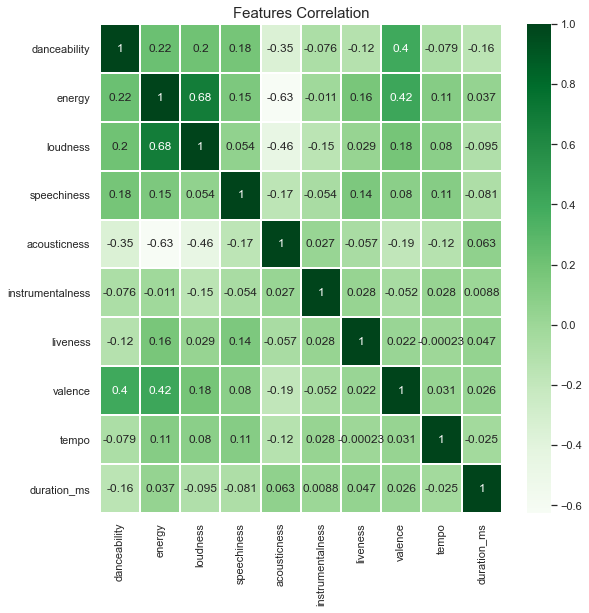

In [36]:
# Correlation plot - Heatmap
corr=df[song_features_cont].corr()
ax = plt.figure(figsize=(9,9))
sns.heatmap(corr,
            annot=True,
            linewidths=1,
            cmap="Greens")
plt.title("Features Correlation",size=15)
plt.show();

Above heatmap gives us the idea of linear correlation between features with pearson correlation coefficient. Linear correlation can be positive or negative. 
- in negative correlation, one feature value increase if other feature value is decreasing.
- in positive correlation one feature value increase if other feature value is aslo increasing

As it seems, these features are correlated
- valence and danceability
- valence and energy
- acousticness and loudness
- acousticness and energy
- loudness and energy


we are going to plot these relations between features below

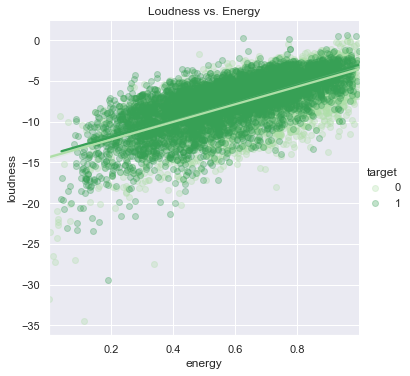

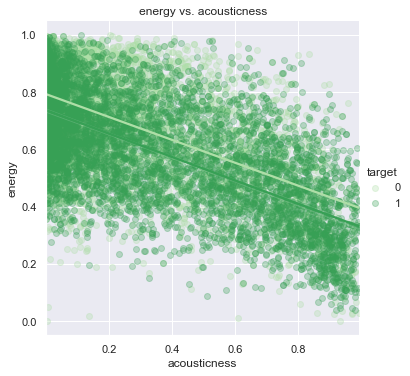

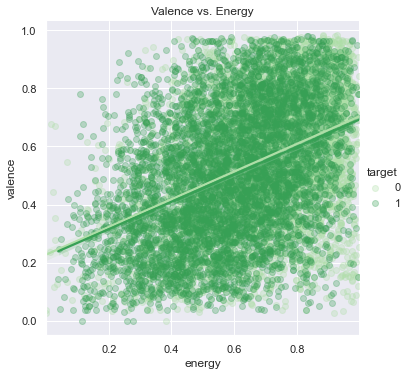

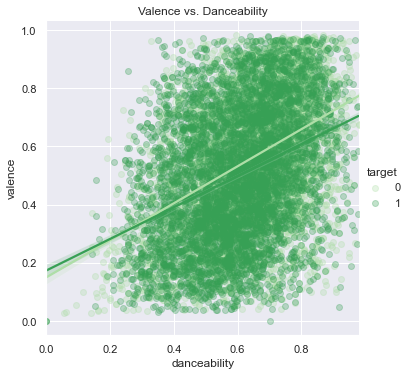

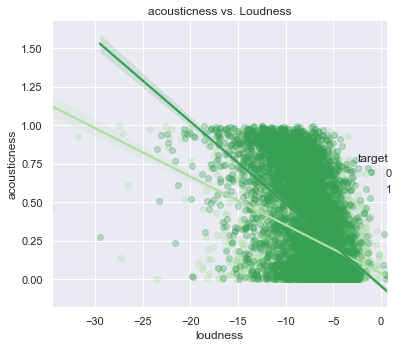

In [41]:
#loudness vs energy
sns.lmplot(y='loudness',x='energy',data=df, hue='target',scatter_kws={'alpha':0.3},palette='Greens')
plt.title('Loudness vs. Energy')
#energy vs acousticness
sns.lmplot(y='energy',x='acousticness',data=df, hue='target',scatter_kws={'alpha':0.3},palette='Greens')
plt.title('energy vs. acousticness')
# Valence and Energy
sns.lmplot(y='valence',x='energy',data=df, hue='target',scatter_kws={'alpha':0.3},palette='Greens')
plt.title('Valence vs. Energy')
# Valence and Danceability
sns.lmplot(y='valence',x='danceability',data=df, hue='target',scatter_kws={'alpha':0.3},palette='Greens')
plt.title('Valence vs. Danceability')
# acousticness and Loudness
sns.lmplot(y='acousticness',x='loudness',data=df, hue='target',scatter_kws={'alpha':0.3},palette='Greens')
plt.title('acousticness vs. Loudness')
plt.tight_layout();

we will perform PCA for dimesionality reduction

In [42]:
# PCA for dimensionality reduction and visualization

# Feature's scaling
# Initializing scaler
scaler = StandardScaler()
# Separating features from target ('like')
songs_df_std = df[song_features_cont+song_features_cat].values
y = df[song_target].values
# Standardizing features
songs_df_std = StandardScaler().fit_transform(songs_df_std)

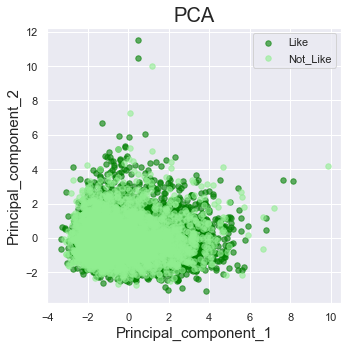

In [43]:
# PCA - Data projection in 2D
pca = PCA(n_components=2)
principal_components = pca.fit_transform(songs_df_std)
principal_df = pd.DataFrame(data = principal_components, 
                            columns = ['principal component 1', 'principal component 2'])
# Concatenate std features and target ('like')
songs_df_std_target = pd.concat([principal_df, df[[song_target]]], 
                                axis = 1)

# Plot 2D PCA
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal_component_1', fontsize = 15)
ax.set_ylabel('Principal_component_2', fontsize = 15)
targets = [1, 0]
colors = ['green', 'lightgreen']
for target, color in zip(targets, colors):
    idx = songs_df_std_target['target'] == target
    ax.scatter(songs_df_std_target.loc[idx, 'principal component 1'], 
               songs_df_std_target.loc[idx, 'principal component 2'], 
               c = color,
               s = 30,
               alpha=0.6
              )
ax.legend(['Like','Not_Like'])
plt.title('PCA', fontsize = 20)
plt.tight_layout()


In [44]:
#Explained Variance by the two first principal components
pca.explained_variance_ratio_

array([0.20824602, 0.09807221])

As we can see in the above plot, our liked and disliked songs are not distinguishable at all, there is no separation between both categories and the PC1 and PC2 has very less variance ratio which indicates with PCA we will loose alot of information.

## 3. Classifier

In [45]:
from sklearn.utils import shuffle
# shuffle the dataframe
df = shuffle(df, random_state=0).reset_index(drop=True)


In [46]:
# create validation set
validation_set = df.iloc[:1000]
validation_set.shape

(1000, 14)

In [47]:
# dataset for cv
df_ = df.iloc[1000:]
df_.shape

(10038, 14)

In [48]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [50]:
# Model 1. Baseline Model - Logistic regression - All features

# Get features X and target y
X, y = df_[song_features_cont+song_features_cat], df_[song_target]

# Define evaluation procedure - 3-Fold cross validation
cross_val = RepeatedStratifiedKFold(n_splits=3, n_repeats=5)

# Instantiate model
logistic_model = LogisticRegression()


# Fit and evaluate model with all
# use standardized data
logit_scores = cross_val_score(logistic_model, X, y, scoring='f1', cv=cross_val, n_jobs=-1)


# Summarize performance
print(f'Mean f1-score: {logit_scores.mean()}')

# Create f1_score dict - To save models performance
f1_score = {}

# Add to f1_score dict
f1_score['logistic_baseline'] = logit_scores.mean()

Mean f1-score: 0.3333858296817221


In [51]:
# Model 2. Decision Tree

# Instantiate model
tree_model = DecisionTreeClassifier(max_depth=5)

# Fit and evaluate model with all features
tree_scores = cross_val_score(tree_model, 
                              X, 
                              y, 
                              scoring='f1', 
                              cv=cross_val, 
                              n_jobs=-1
                             )

# Summarize performance
print(f'Mean f1-score: {tree_scores.mean()}')

# Add to ROC AUC dict
f1_score['decision_tree'] = tree_scores.mean()

Mean f1-score: 0.6264733049231878


In [52]:
# Model 3. Random Forest

# Instantiate model
rf_model = RandomForestClassifier(max_depth=5)

rf_model.fit(X,y)
# Fit and evaluate model with all features
rf_scores = cross_val_score(rf_model, 
                            X,
                            y, 
                            scoring='f1', 
                            cv=cross_val, 
                            n_jobs=4
                           )


# Summarize performance
print(f'Mean f1-score: {rf_scores.mean()}')

# Add to ROC AUC dict
f1_score['random_forest'] = rf_scores.mean()

Mean f1-score: 0.6622442140401003


In [53]:
# Model 4. ADA Boost

# Instantiate model
ada_model = AdaBoostClassifier() #base_estimator = LogisticRegression()

# Fit and evaluate model with all features
ada_scores = cross_val_score(ada_model,
                             X, 
                             y, 
                             scoring='f1', 
                             cv=cross_val, 
                             n_jobs=-1
                            )

# Summarize performance
print(f'Mean f1-score: {ada_scores.mean()}')

# Add to ROC AUC dict
f1_score['ada_boost'] = ada_scores.mean()


Mean f1-score: 0.6537211634656986


In [54]:
# Model 5. XGBoost

# Instantiate model
xgb_model = XGBClassifier()

# Fit and evaluate model with all features
xgb_scores = cross_val_score(xgb_model, 
                             X, 
                             y, 
                             scoring='f1',
                             cv=cross_val, 
                             n_jobs=-1
                            )

# Summarize performance
print(f'Mean f1-score: {xgb_scores.mean()}')

# Add to ROC AUC dict
f1_score['xg_boost'] = xgb_scores.mean()

Mean f1-score: 0.6301392318132613


In [57]:
f1_score

{'logistic_baseline': 0.3333858296817221,
 'decision_tree': 0.6264733049231878,
 'random_forest': 0.6622442140401003,
 'ada_boost': 0.6537211634656986,
 'xg_boost': 0.6301392318132613}

use gridsearchCV for hyperparameter tuning

In [58]:
from sklearn.model_selection import GridSearchCV

for random forest model

In [59]:
forest = RandomForestClassifier()
n_estimators = [100, 300, 500, 800]
max_depth = [5,7, 8, 15, 25]
min_samples_split = [2, 5, 10, 15,20]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = 4)
bestF = gridF.fit(X, y)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


In [60]:
bestF.best_params_

{'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 300}

In [61]:
# Model 6. Random Forest optimized

# Instantiate model
rf_model_opt = RandomForestClassifier(max_depth=7,min_samples_leaf= 1,min_samples_split=5,n_estimators=300)

rf_model_opt.fit(X,y)
# Fit and evaluate model with all features
rf_scores_opt = cross_val_score(rf_model_opt, 
                            X,
                            y, 
                            scoring='f1', 
                            cv=cross_val, 
                            n_jobs=4
                           )


# Summarize performance
print(f'Mean f1-score: {rf_scores_opt.mean()}')

# Add to ROC AUC dict
f1_score['random_forest_opt'] = rf_scores_opt.mean()

Mean f1-score: 0.6707838216809989


Optimized Ada boost

In [62]:
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

parameters = {'base_estimator__max_depth':[i for i in range(2,11,2)],
              'base_estimator__min_samples_leaf':[5,10],
              'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.1]}

clf = GridSearchCV(abc, parameters,verbose=3,scoring='f1',n_jobs=4)
best_ada = clf.fit(X,y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


In [63]:
best_ada.best_params_

{'base_estimator__max_depth': 4,
 'base_estimator__min_samples_leaf': 10,
 'learning_rate': 0.1,
 'n_estimators': 50}

In [67]:
# Model 7. ADA Boost optimized

# Instantiate model
ada_model_opt = AdaBoostClassifier(base_estimator=DecisionTreeClassifier( max_depth=4,min_samples_leaf=10),
                                  n_estimators=50,learning_rate=0.1) 

# Fit and evaluate model with all features
ada_scores_opt = cross_val_score(ada_model_opt,
                             X, 
                             y, 
                             scoring='f1', 
                             cv=cross_val, 
                             n_jobs=-1
                            )

# Summarize performance
print(f'Mean f1-score: {ada_scores_opt.mean()}')

# Add to ROC AUC dict
f1_score['ada_boost_opt'] = ada_scores_opt.mean()


Mean f1-score: 0.6653329741096347


XGboost optimized

In [ ]:
# Hyperparameter tunning for XGBoost
ratio = (1 - y).sum() / y.sum() # proportion of like not_like
param_grid = {
    'max_depth': [4,5,6,7],
    'n_estimators': list(range(200, 600)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.1), base = 10, num = 1000)),
    'reg_alpha': list(np.linspace(0.5, 1.5)),
    'reg_lambda': list(np.linspace(0.5, 1.5)),
    'gamma': [0,5,10,15,20],
    'colsample_bytree': list(np.linspace(0.5, 0.9, 10)),
    'colsample_bylevel':list(np.linspace(0.5, 0.9, 10)),
    'min_child_weight': [5,10,20,30,40],
    'subsample': list(np.linspace(0.5, 1, 100)),
    'scale_pos_weight': np.linspace(ratio-3, ratio+3),
}

rs =GridSearchCV(XGBClassifier(), 
                        param_grid, 
                        scoring='f1', 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=1000)
rs.fit(X, y)
best_params = rs.best_params_
rs.best_params_

In [68]:
# Model 8. XGBoost with hyperparameter tunning

# Instantiate model
xgb_model_opt = XGBClassifier(subsample = 0.8838383838383839,
                          scale_pos_weight = 2.7602040816326525,
                          reg_lambda = 1.0918367346938775,
                          reg_alpha = 1.2959183673469385,
                          n_estimators = 223,
                          min_child_weight = 5,
                          max_depth = 4,
                          learning_rate = 0.05047405878882374,
                          gamma = 0,
                          colsample_bytree = 0.8111111111111111,
                          colsample_bylevel = 0.9)

# Fit and evaluate model with all features
xgb_scores_opt = cross_val_score(xgb_model_opt,
                             X, 
                             y, 
                             scoring='f1',
                             cv=cross_val, 
                             n_jobs=-1
                            )

# Summarize performance
print(f'Mean f1-score: {xgb_scores_opt.mean()}')

# Add to ROC AUC dict
f1_score['xg_boost_opt'] = xgb_scores_opt.mean()


Mean f1-score: 0.7018688101899961


In [69]:

# Metric - f1_score
f1_score

{'logistic_baseline': 0.3333858296817221,
 'decision_tree': 0.6264733049231878,
 'random_forest': 0.6622442140401003,
 'ada_boost': 0.6537211634656986,
 'xg_boost': 0.6301392318132613,
 'random_forest_opt': 0.6707838216809989,
 'ada_boost_opt': 0.6653329741096347,
 'xg_boost_opt': 0.7018688101899961}

XGBoost is performing best compare to other models after parameter tuning.

We are going to validate our xg boost optimized model with unknown data

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:41:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


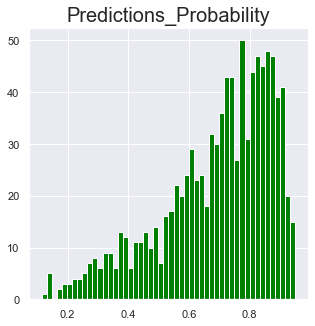

In [96]:
# Validation set
X_val = validation_set[song_features_cont+song_features_cat]

# Model fit using all train data with all features
xgb_model_opt.fit(X, y)

# Predictions on validation set data: 
predictions = xgb_model_opt.predict(X_val)
predictions_prob = xgb_model_opt.predict_proba(X_val)[:,1] #It returns prob of being zero or one, subselect second column (prob of being one)

# Plot
plt.figure(figsize=(5,5))
plt.hist(predictions_prob, 
         bins=50,
         color='green'
        )
plt.title('Predictions_Probability', fontsize = 20)
plt.show()

In [97]:
# Add predictions to validation df
discover_df_pred = validation_set.copy()
discover_df_pred['like_prediction'] = predictions
discover_df_pred['like_probability'] = predictions_prob
discover_df_pred

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,target,like_prediction,like_probability
0,0.663,0.964,7,-5.503,1,0.0366,0.001740,0.091300,0.4270,0.8560,121.021,225133,4,0,1,0.551839
1,0.581,0.684,1,-4.962,0,0.0429,0.017900,0.000019,0.0849,0.0397,129.966,202439,4,1,1,0.854687
2,0.404,0.361,8,-8.904,1,0.0520,0.775000,0.000000,0.1950,0.5850,98.020,228693,4,1,1,0.862931
3,0.768,0.864,11,-6.145,1,0.0324,0.101000,0.000000,0.1620,0.8910,110.008,173027,4,1,1,0.727834
4,0.591,0.828,4,-5.895,1,0.0333,0.000184,0.001130,0.0879,0.3830,129.962,295720,4,1,1,0.585748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.556,0.701,2,-6.537,1,0.0346,0.037400,0.000000,0.1220,0.9270,139.981,223947,4,0,1,0.831703
996,0.879,0.522,5,-8.934,0,0.0690,0.068000,0.000000,0.0988,0.3260,99.997,165600,4,1,1,0.689521
997,0.495,0.333,4,-10.109,0,0.0288,0.737000,0.000000,0.1120,0.3700,99.757,158324,4,1,1,0.890183
998,0.522,0.243,1,-7.796,1,0.0461,0.874000,0.000000,0.0980,0.5690,119.341,231668,3,0,1,0.922480


In [98]:
# Confusion matrix for validation set
from sklearn.metrics import confusion_matrix

# Import manual classification
y_true = discover_df_pred['target']
# Predictions
y_pred = discover_df_pred['like_prediction']

# Get confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print(f'True_Pos: {tp}\nFalse_Pos: {fp}\nFalse_Neg: {fn}\nTrue_Neg: {tn}')


True_Pos: 462
False_Pos: 376
False_Neg: 32
True_Neg: 130


In [99]:

# Calculate precision and recall
precision = tp / (tp+fp)
recall = tp / (tp+fn)
print(f'Precision: {precision}\nRecall: {recall}')

Precision: 0.5513126491646778
Recall: 0.9352226720647774


In [100]:
# Calculate f1_score for validation data
f1_score = 2*(precision*recall)/(precision + recall)
print("f1 score for validation set:",f1_score)

f1 score for validation set: 0.6936936936936937
